# Content Dimension: text classification

### Features
* BoW
* TF-IDF
* W2V

In [1]:
import pandas as pd
from utils import preprocess
from sklearn.linear_model import LogisticRegression
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load data

In [2]:
import pandas as pd

df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')


In [3]:
df_train

,text,misinformation,original,id_message,preprocessed_text
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...
...,...,...,...,...,...
6228,ATENÇÃO ELEITORES DE BOLSONARO EM BELÉM DO PAR...,0,1,3301,atarncao eleitor bolsonaro belem parar \n \n c...
6229,"""DITA DURA"".\n\nPara:\n""Ninguém é igual a ning...",1,1,3302,dizer duro \n \n \n ninguem igual ninguem todo...
6230,GRANDE CARLOS DRUMOND DE ANDRADE: ...,1,0,3302,grande carlos drumond andrade dizer duro \n \n...
6231,"CARLOS DRUMOND DE ANDRADE\n\nDITA DURA\n""Ningu...",1,0,3302,carlos drumond andrade \n \n dizer duro \n nin...


In [4]:
for t in df_train['text']:
    if 'facebook' in t:
        print(t)
        break

*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA PARA AJUDAR O NOSSO PRESIDENTE ESTÁ AQUI:*

https://m.facebook.com/story.php?story_fbid=525897467858283&id=243021376285804


In [5]:
df_train.groupby(by='misinformation').count()['text']

misinformation
0    3255
1    2978
Name: text, dtype: int64

In [6]:
df_train.groupby(by='misinformation')['original'].sum()

misinformation
0    1905
1    1399
Name: original, dtype: int64

In [7]:
df_test.groupby(by='misinformation').count()['text']

misinformation
0    834
1    740
Name: text, dtype: int64

In [8]:
df_test.groupby(by='misinformation')['original'].sum()

misinformation
0    486
1    341
Name: original, dtype: int64

### Preprocess

In [9]:
from utils import preprocess

In [10]:
df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]

In [11]:
df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]

In [12]:
y_train = df_train['misinformation']
y_test = df_test['misinformation']

In [13]:
from sklearn.linear_model import LogisticRegression
import utils

# TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train['preprocessed_text'])   
X_train = tfidf.transform(df_train['preprocessed_text'])
X_test = tfidf.transform(df_test['preprocessed_text'])

logistic regression + tf-idf
0.48
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       834
           1       0.78      0.87      0.82       740

    accuracy                           0.82      1574
   macro avg       0.82      0.82      0.82      1574
weighted avg       0.83      0.82      0.82      1574

AUC:  0.9021679953334629


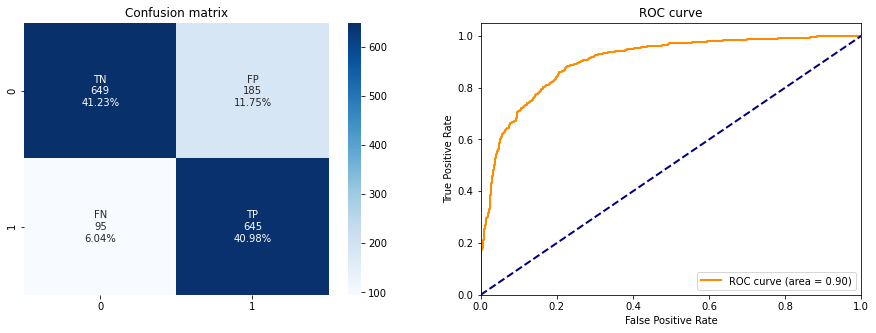

0,822
0,177
0,777
0,871
0,821
0,902


(0.8221092757306226,
 0.17743979721166026,
 0.7771084337349398,
 0.8716216216216216,
 0.821656050955414,
 0.9021679953334629)

In [15]:
print('logistic regression + tf-idf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [16]:
np.argsort(np.max(lr.coef_, axis=0))[-2]

15426

In [17]:
lr.coef_.min()

-2.179015130747964

In [18]:
[lr.coef_==0][0][0]

array([False, False, False, ..., False, False, False])

In [19]:
print('words with highest positive value')
for n in range(10):
    k = -n-1
    print(tfidf.get_feature_names()[np.argsort(np.max(lr.coef_, axis=0))[k]])

words with highest positive value
video
audio
pt
compartilhar
repassar
tentar
governar
youtube
rosto_furioso
ver


In [20]:
print('words with lowest negative value')
for n in range(10):
    k = n
    print('\item ' + tfidf.get_feature_names()[np.argsort(np.max(lr.coef_, axis=0))[k]])

words with lowest negative value
\item bolsonaro
\item chat whatsapp
\item chat
\item dia
\item rolando_no
\item rosto_sorridente
\item postar
\item feirar
\item whatsapp
\item bandeira_brasil


## example interpretation of a prediction

In [21]:
for i,p in enumerate(df_test['text'][TP]):
    print(i,p)

NameError: name 'TP' is not defined

In [88]:
example = list(df_test['text'][TP])[45]
print(example)
example = utils.preprocess(example)

*😨 BOLSONARO SOB AMEAÇA!*

REPASSEM URGENTE! 

SARNEY ESTÁ FURIOSO E JÁ SE REUNIU COM TEMER, DILMA, E A GLOBO E FIZERAM UMA AMEAÇA CONTRA BOLSONARO,DIZENDO Q ELE GANHARÁ MAS NÃO ASSUMIRÁ GOVERNO, SERÁ IGUAL O QUE FIZERAM COM O PRESIDENTE TANCREDO NEVES.

Pessoa isso é muito sério! AGORA Como eles viram que já perderam nas urnas fraudadas, agora partiram para ameaça de morte! A reportagem divulgada hoje, SARNEY AMEAÇA BOLSONARO dizendo que "Vence mas não assumirá o cargo"

Está mais que claro que nosso batalha não será apenas no dia da votação, nossa batalha é contra o Mau. 

🙏🏼REPASSEM ESTA INFORMAÇÃO ANTES QUE SEJA REMOVIDO DO WHATSAPP E FACEBOOK PELA TV GLOBO.

http://www.gshowplay.com/2018/09/sarney-diz-que-se-bolsonaro-vence-mas.html?m=1


In [89]:
x = tfidf.transform([example])
x = x.todense()
x = np.asarray(x)
lr.predict_proba(x)

array([[0.37028077, 0.62971923]])

In [90]:
coefs = lr.coef_
x.shape == coefs.shape

True

In [95]:
interpret = pd.DataFrame({'termo':tfidf.get_feature_names(), 'valor': (coefs*x).flatten()})

In [101]:
top_20 = interpret[interpret['valor']!=0].sort_values(by='valor', ascending= True).reset_index(drop=True)[:20]
top_20

,termo,valor
0,dia,-0.092037
1,whatsapp,-0.091155
2,bolsonaro dizer,-0.084334
3,remover,-0.081675
4,bolsonaro,-0.075765
5,facebook,-0.049254
6,maos_juntas,-0.043683
7,votacao,-0.042481
8,tv globo,-0.040168
9,agora partir,-0.034698


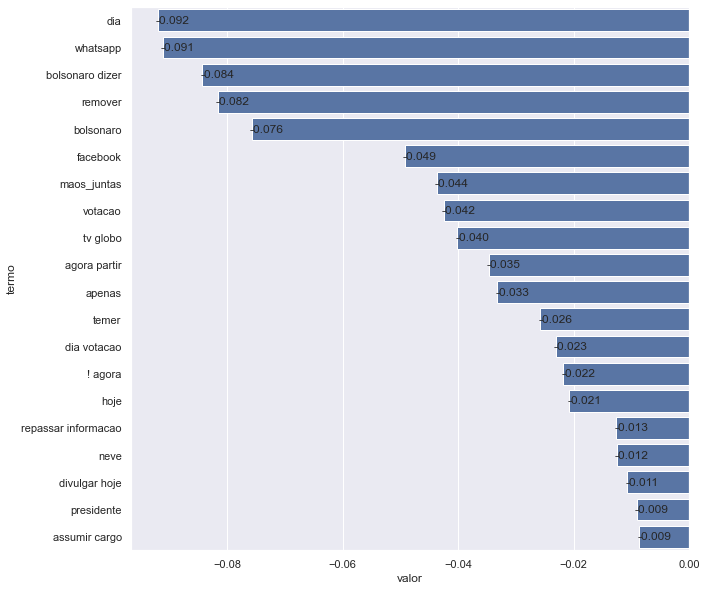

In [102]:
plt.figure(figsize=(10,10))
#plt.xticks(top_20['valor'], top_20['termo'] , rotation='0')
g = sns.barplot(y='termo',x = 'valor',data=top_20, color = 'C0')
for p in g.patches:
        g.annotate(format(p.get_width(), '.3f'), (p.get_width(), 
                                                    p.get_y() + p.get_height()/2.), ha = 'center', 
                    va = 'center', xytext = (15, 0), textcoords = 'offset points')

# Errors

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       834
           1       0.79      0.83      0.81       740

    accuracy                           0.82      1574
   macro avg       0.82      0.82      0.82      1574
weighted avg       0.82      0.82      0.82      1574

Total test data: 1574
Negative in test data: 834
Positive in test data: 740
False negative:  126
False positive:  163


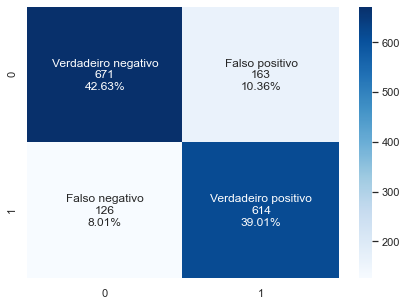

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
#clf = MLPClassifier(verbose=True, early_stopping= True, batch_size=64, n_iter_no_change = 5, tol = 1e-3).fit(X_train, y_train)
y_pred = lr.predict(X_test)
#y_prob = clf.predict_proba(X_test)[:,1]
#getTestMetrics(y_test, y_pred, full_metrics = False, print_charts=True)

print(metrics.classification_report(y_test, y_pred))
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7, 5))
#plt.subplot(121)
#plt.title('Confusion matrix - LSVM with only long texts')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


y_fails = y_test - y_pred
N = [index for index, value in enumerate(y_test) if value == 0]
P = [index for index, value in enumerate(y_test) if value == 1]
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

# 1 + 1 = 2 TP
# 0 + 0 = 0 TN
y_sucess = y_test + y_pred
TN = [index for index, value in enumerate(y_sucess) if value == 0]
TP = [index for index, value in enumerate(y_sucess) if value == 2]

print('Total test data:', len(y_pred))
print('Negative in test data:',len(N))
print('Positive in test data:',len(P))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

In [23]:
full_texts_test = df_test['text']

In [24]:
texts_N = [full_texts_test[n] for n in N]
texts_P = [full_texts_test[p] for p in P]
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]
texts_TN = [full_texts_test[fn] for fn in TN]
texts_TP = [full_texts_test[fp] for fp in TP]

In [25]:
for fn in texts_FN:
    print('\n\n-----------------------')
    print(fn)
    print('----------------------\n\n')



-----------------------
Líder PCC preso em São Paulo ontem externa toda sua ousadia perante policiais. ameaçando  policiais e promotor.
Importante divulgar para que a sociedade tenha ciência o que passa um policial todos os dias no seu trabalho...
----------------------




-----------------------
🗣 Amanhã, as 10:00 hs, na praça da Matriz, um monge estará benzendo as pessoas para tirar o *PT* da cabeça, não falte!
😂 😂🤣😂
----------------------




-----------------------
*NÃO PODEMOS DESISTIR: AINDA HÁ TEMPO*
*DE LUTAR POR ELEIÇÕES LIMPAS E ABERTAS*

Vamos pressionar pela aprovação do Decreto Legislativo que OBRIGA a adoção de urnas de lona e voto em cédula de papel ainda nesta Eleições 2018! Faça sua parte, ajude a pressionar, veja a lista de contatos dos senadores no texto que acompanha este banner:

#ForaUrnasEletrônicas #VotoNaCédulaJá #Eleições2018

https://www.facebook.com/Candidato.Sem.Partido/photos/a.1389858391158965/1406516989493105/?type=3
----------------------




-------

In [26]:
# curto com info externa: 0
# longo com info externa mídia externa: 1
# curto sem info externa: 2
# longo sem info externa: 3
# fn_class = []
# for fn in texts_FN:
#     print()
#     if len(fn.split()) > 50:
#         print('LONGO')
#     else: 
#         print('CURTO')
#     print(fn)
#     fn_class.append(input('classificação: '))
    
#     print('\n-----------------------------------')
# unique, counts = np.unique(np.array(fn_class), return_counts=True)
# dict(zip(unique, counts))

{'0': 75, '1': 14, '2': 16, '3': 20}

In [27]:
# curto com info externa: 0
# longo com info externa mídia externa: 1
# curto sem info externa: 2
# longo sem info externa: 3
# fp_class = []
# for i,fp in enumerate(texts_FP):
#     print('{}/{}'.format(i,len(texts_FP)))
#     print()
#     print(fp)    
#     if len(fp.split()) > 50:
#         print('LONGO')
#     else: 
#         print('CURTO')
        
#     fp_class.append(input('classificação: '))
    
    
#     print('\n-----------------------------------')
# fp_class = fn_class[len(texts_FN):]
# unique, counts = np.unique(np.array(fp_class), return_counts=True)
# dict(zip(unique, counts))

{'0': 89, '1': 11, '2': 12, '3': 76}

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


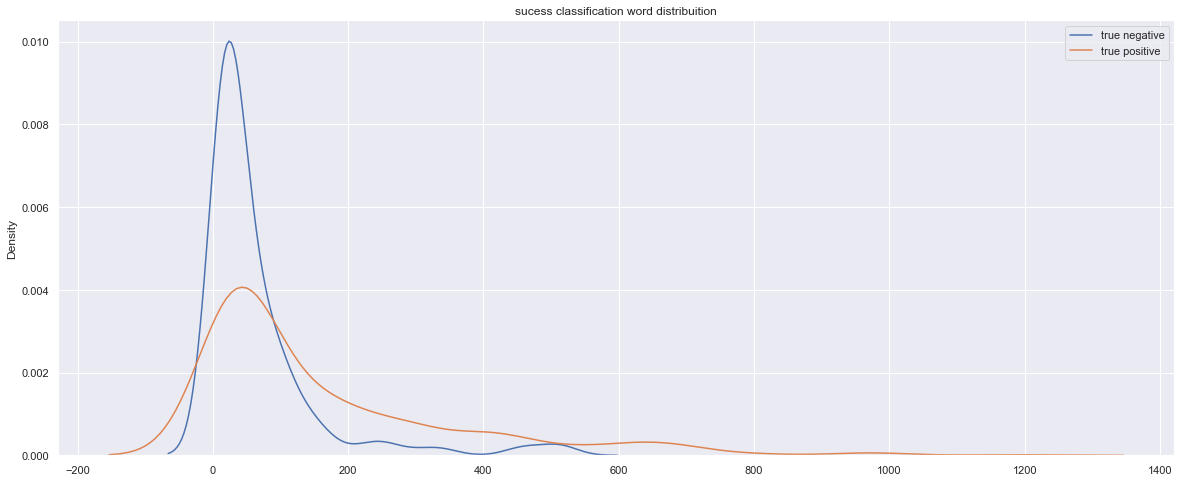

In [28]:
fn_tokens = np.array([len(t.split()) for t in texts_FN])
fp_tokens = np.array([len(t.split()) for t in texts_FP])
tn_tokens = np.array([len(t.split()) for t in texts_TN])
tp_tokens = np.array([len(t.split()) for t in texts_TP])
p_tokens = np.array([len(t.split()) for t in texts_P])
n_tokens = np.array([len(t.split()) for t in texts_N])
test_tokens = np.array([len(t.split()) for t in full_texts_test])

plt.figure(figsize=(20, 8))
plt.title('sucess classification word distribuition')
sns.distplot(tn_tokens, hist = False, kde = True, label = 'true negative')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'true positive')
plt.legend()
plt.show()

In [29]:
pd.Series(test_tokens).quantile(0.55)

51.0

In [30]:
pd.Series(test_tokens).describe()

count    1574.000000
mean      106.837357
std       154.665746
min        10.000000
25%        20.000000
50%        40.000000
75%       113.750000
max      1183.000000
dtype: float64

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


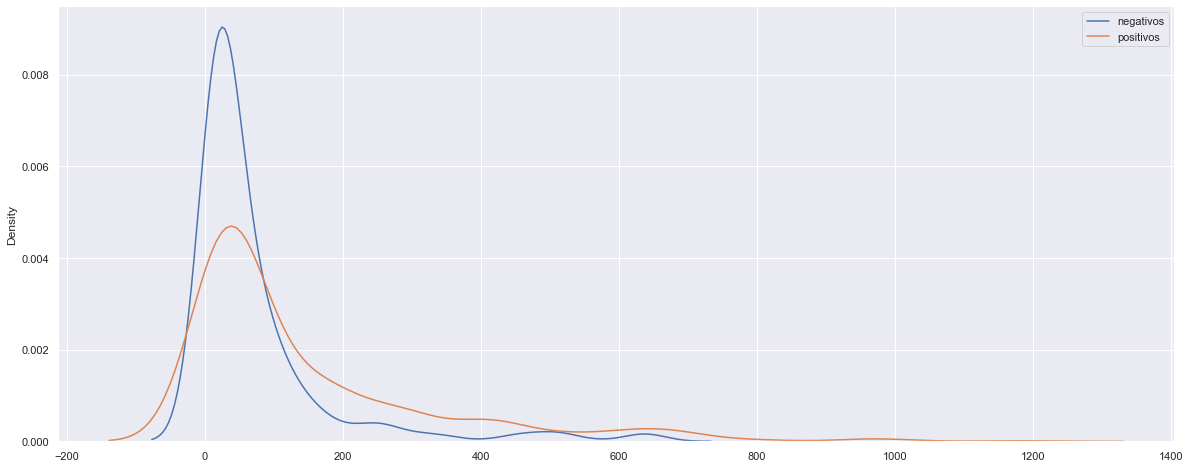

In [40]:
plt.figure(figsize=(20, 8))
#plt.title('negative classification word distribuition')
sns.distplot(n_tokens, hist = False, kde = True, label = 'negativos')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positivos')
#sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.legend()
plt.show()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


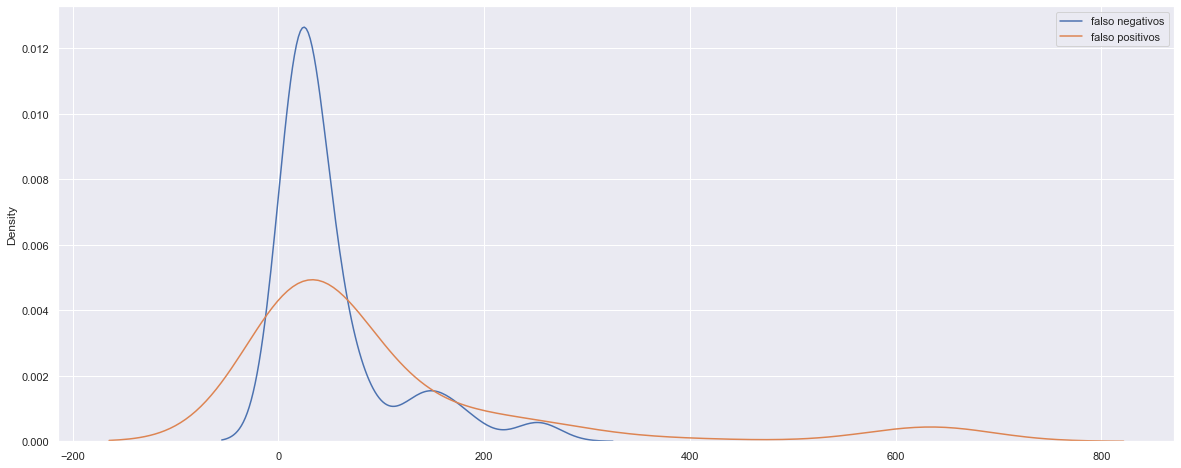

In [41]:
plt.figure(figsize=(20, 8))
#plt.title('negative classification word distribuition')
sns.distplot(fn_tokens, hist = False, kde = True, label = 'falso negativos')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'falso positivos')
#sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.legend()
plt.show()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

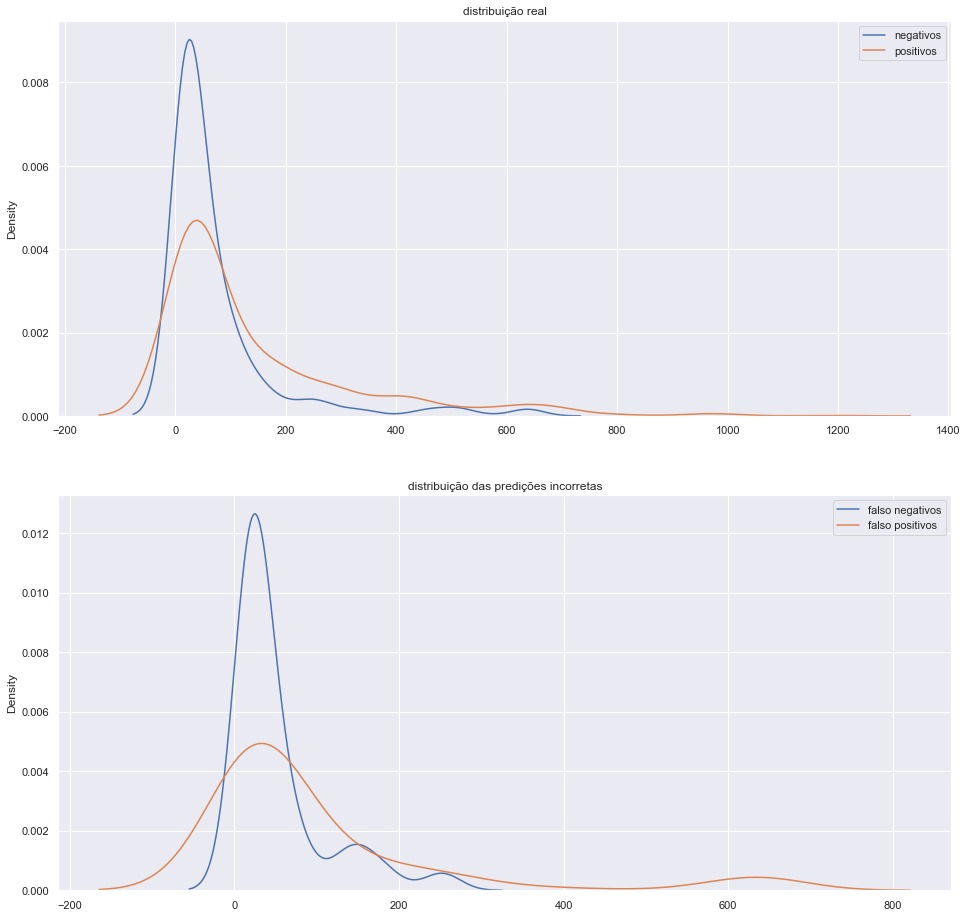

In [46]:
plt.figure(figsize=(16, 16))
plt.subplot(211)
plt.title('distribuição real')
sns.distplot(n_tokens, hist = False, kde = True, label = 'negativos')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positivos')
plt.legend()
plt.subplot(212)
plt.title('distribuição das predições incorretas')
sns.distplot(fn_tokens, hist = False, kde = True, label = 'falso negativos')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'falso positivos')
#sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.legend()
plt.show()

In [72]:
n = 550
print((n_tokens>n).sum())
print((p_tokens>n).sum())
print((pred_pos_tokens>n).sum())
print((pred_neg_tokens>n).sum())

11
42
53
0


39

In [69]:
pred_pos_tokens = np.concatenate((fp_tokens, tp_tokens), axis=0) 


49

In [66]:
pred_neg_tokens = np.concatenate((fn_tokens, tn_tokens), axis=0)
(pred_neg_tokens>600).sum()

0

In [52]:
(tp_tokens>800).sum()

7

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


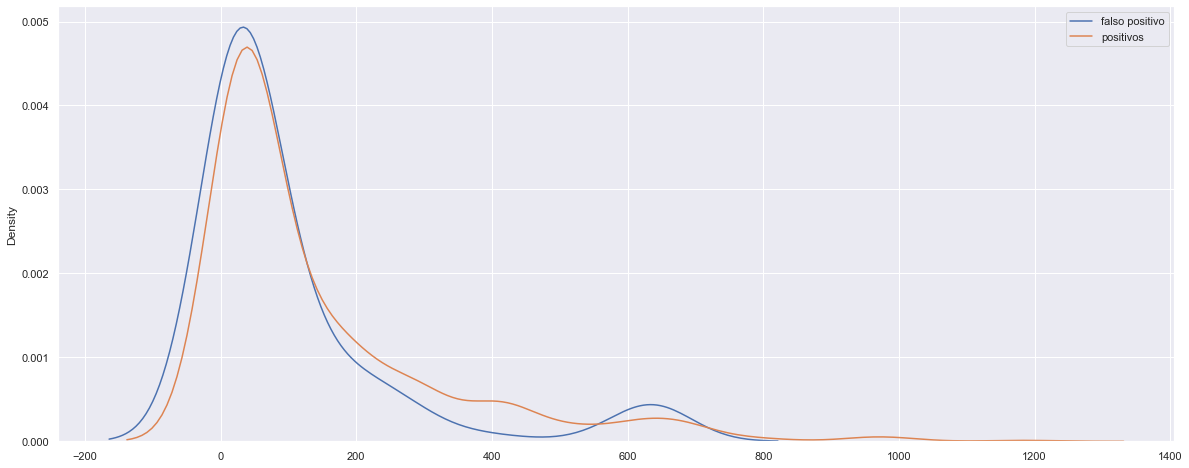

In [39]:
plt.figure(figsize=(20, 8))
#plt.title('negative classification word distribuition')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'falso positivo')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positivos')
#sns.distplot(n_tokens, hist = False, kde = True, label = 'negative')
plt.legend()
plt.show()

positivos e falso positivos


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

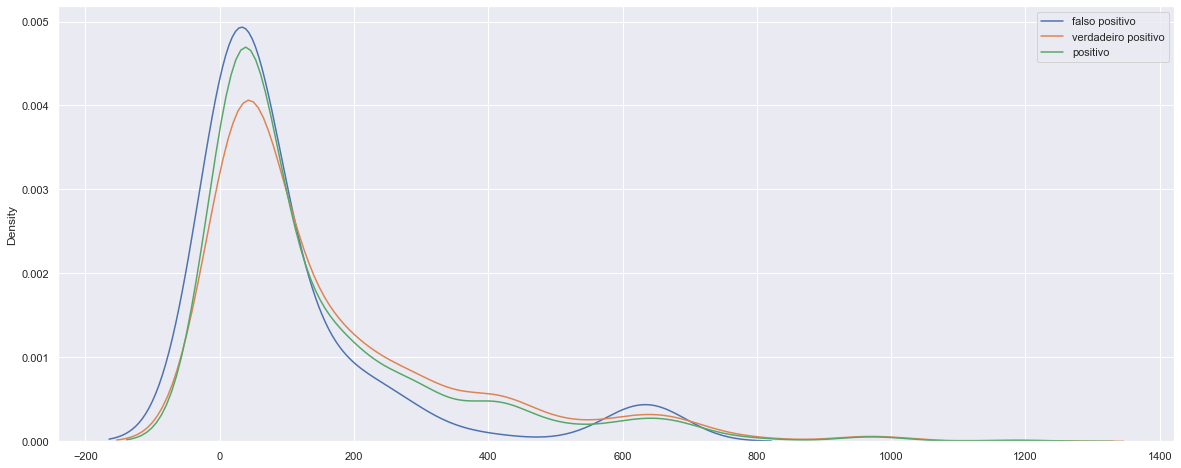

In [32]:
plt.figure(figsize=(20, 8))
print('positivos e falso positivos')
#plt.title('positive classification word distribuition')
sns.distplot(fp_tokens, hist = False, kde = True, label = 'falso positivo')
sns.distplot(tp_tokens, hist = False, kde = True, label = 'verdadeiro positivo')
sns.distplot(p_tokens, hist = False, kde = True, label = 'positivo')
plt.legend()
plt.show()

distribuição de palavras entre erros


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

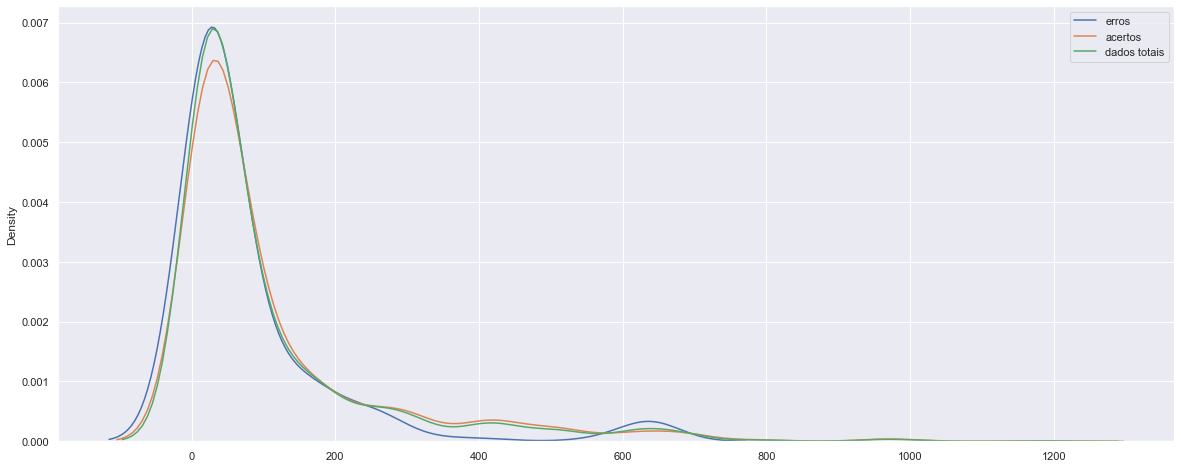

In [33]:
print('distribuição de palavras entre erros')
correct = np.concatenate((tn_tokens, tp_tokens), axis=0) 
errors = np.concatenate((fn_tokens, fp_tokens), axis=0)
plt.figure(figsize=(20, 8))
#plt.title('sucess classification word distribuition')

sns.distplot(errors, hist = False, kde = True, label = 'erros')
sns.distplot(correct, hist = False, kde = True, label = 'acertos')
sns.distplot(test_tokens, hist = False, kde = True, label = 'dados totais')
plt.legend()
plt.show()

distribuição de palavras entre erros


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


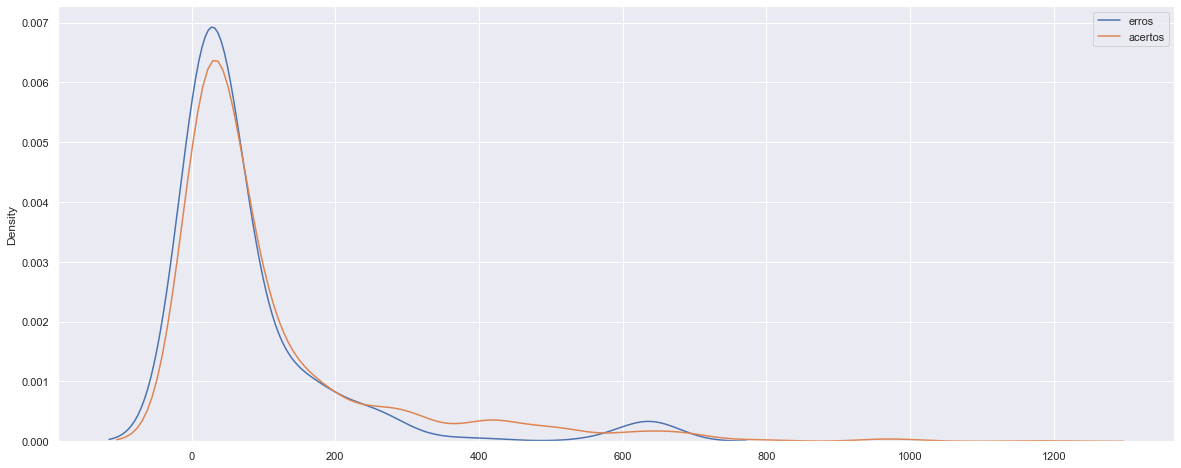

In [34]:
print('distribuição de palavras entre erros')
correct = np.concatenate((tn_tokens, tp_tokens), axis=0) 
errors = np.concatenate((fn_tokens, fp_tokens), axis=0)
plt.figure(figsize=(20, 8))
#plt.title('sucess classification word distribuition')

sns.distplot(errors, hist = False, kde = True, label = 'erros')
sns.distplot(correct, hist = False, kde = True, label = 'acertos')
plt.legend()
plt.show()

distribuição de palavras entre erros


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


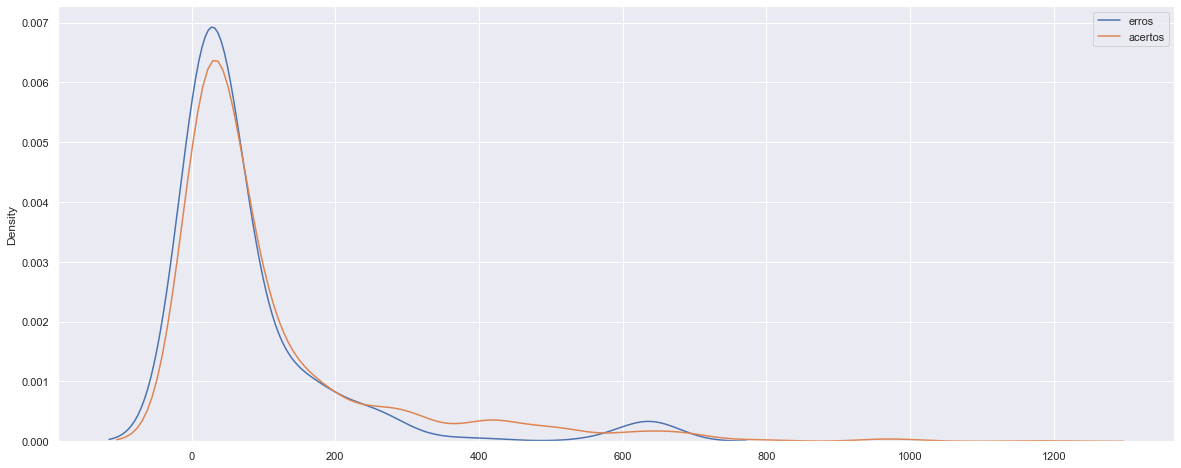

In [34]:
print('distribuição de palavras entre erros')
correct = np.concatenate((tn_tokens, tp_tokens), axis=0) 
errors = np.concatenate((fn_tokens, fp_tokens), axis=0)
plt.figure(figsize=(20, 8))
#plt.title('sucess classification word distribuition')

sns.distplot(errors, hist = False, kde = True, label = 'erros')
sns.distplot(correct, hist = False, kde = True, label = 'acertos')
plt.legend()
plt.show()

textos longos incorretos:  709
textos curtos incorretos:  865


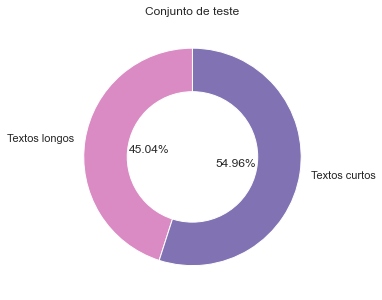

In [35]:
longs = 0
shorts = 0
for c in test_tokens:
    if c > 50:
        longs += 1
    else:
        shorts += 1
print('textos longos incorretos: ', longs)
print('textos curtos incorretos: ', shorts)

# midia and text
#plt.style.use('default')
#plt.style.use('bmh')
plt.figure(figsize=(5, 5))
plt.title('Conjunto de teste')
x = [longs,shorts]
names = ['Textos longos','Textos curtos']
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(x, labels=names,autopct='%1.2f%%',startangle=90, pctdistance=0.4, colors = ['C6','C4'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

textos longos corretos:  610
textos curtos corretos:  675


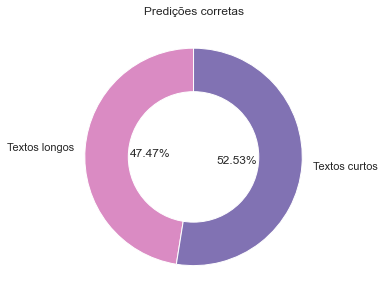

In [36]:
longs_correct = 0
shorts_correct = 0
for c in correct:
    if c > 50:
        longs_correct += 1
    else:
        shorts_correct += 1
print('textos longos corretos: ', longs_correct)
print('textos curtos corretos: ', shorts_correct)

# midia and text
#plt.style.use('default')
#plt.style.use('bmh')
plt.figure(figsize=(5, 5))
plt.title('Predições corretas')
x = [longs_correct,shorts_correct]
names = ['Textos longos','Textos curtos']
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(x, labels=names,autopct='%1.2f%%',startangle=90, pctdistance=0.4, colors = ['C6','C4'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

textos longos incorretos:  99
textos curtos incorretos:  190


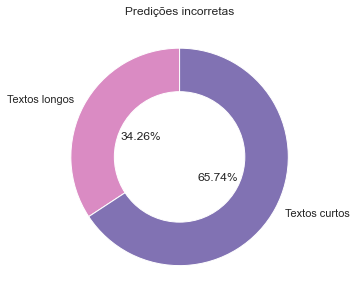

In [37]:
longs_incorrect = 0
shorts_incorrect = 0
for c in errors:
    if c > 50:
        longs_incorrect += 1
    else:
        shorts_incorrect += 1
print('textos longos incorretos: ', longs_incorrect)
print('textos curtos incorretos: ', shorts_incorrect)

# midia and text
#plt.style.use('default')
#plt.style.use('bmh')
plt.figure(figsize=(5, 5))
plt.title('Predições incorretas')
x = [longs_incorrect,shorts_incorrect]
names = ['Textos longos','Textos curtos']
my_circle=plt.Circle( (0,0), 0.6, color='white')
plt.pie(x, labels=names,autopct='%1.2f%%',startangle=90, pctdistance=0.4, colors = ['C6','C4'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Testing other data


In [76]:
df_covid = pd.read_csv('data/wpp_2020.csv')
df_covid['preprocessed'] = [preprocess(t) for t in df_covid['text']]


In [77]:
len(df_covid)

2898

In [79]:
df_covid.groupby('misinformation').count()['text']

misinformation
0    1985
1     913
Name: text, dtype: int64

In [80]:
df_covid.groupby('misinformation').count()['text']/len(df_covid)

misinformation
0    0.684955
1    0.315045
Name: text, dtype: float64

In [82]:
x = tfidf.transform(df_covid['preprocessed'])
y = df_covid['misinformation']

0.48
              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1985
           1       0.52      0.80      0.63       913

    accuracy                           0.70      2898
   macro avg       0.70      0.73      0.69      2898
weighted avg       0.76      0.70      0.71      2898

AUC:  0.804523521151241


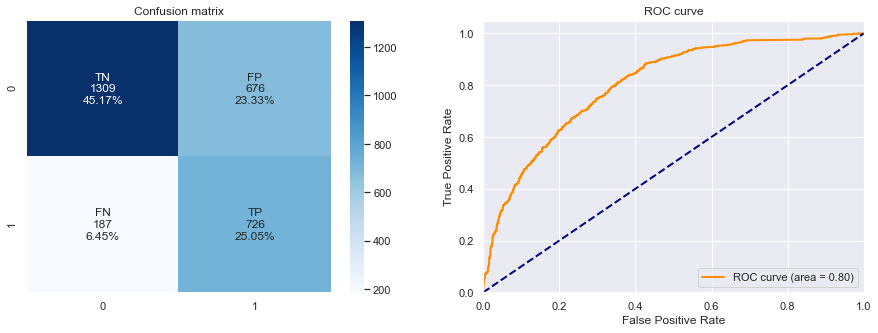

0,702
0,247
0,517
0,795
0,627
0,804


(0.7022084195997239,
 0.2479172651536914,
 0.5178316690442225,
 0.7951807228915663,
 0.6272138228941685,
 0.804523521151241)

In [84]:
y_prob = lr.predict_proba(x)[:,1]
thr = 0.48
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y, y_pred, y_prob, full_metrics = True)

<AxesSubplot:>

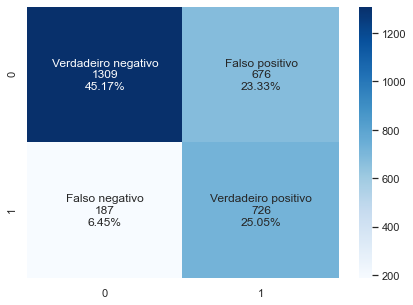

In [85]:
cf_matrix = metrics.confusion_matrix(y, y_pred)
group_names = ['Verdadeiro negativo','Falso positivo','Falso negativo','Verdadeiro positivo']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(7, 5))
#plt.subplot(121)
#plt.title('Confusion matrix - LSVM with only long texts')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# only long texts

In [86]:
df_train['tokens'] = [len(t.split()) for t in df_train['text']]
df_test['tokens'] = [len(t.split()) for t in df_test['text']]

In [97]:
df_train2 = df_train[df_train['tokens'] >= 50]
df_test2 = df_test[df_test['tokens'] >= 50]
y_train = df_train2['misinformation']
y_test = df_test2['misinformation']

In [98]:
df_train[df_train['tokens'] >= 50].groupby('misinformation').count()['text']

misinformation
0    1113
1    1569
Name: text, dtype: int64

In [99]:
df_test[df_test['tokens'] >= 50].groupby('misinformation').count()['text']

misinformation
0    300
1    413
Name: text, dtype: int64

In [100]:
len(y_train)

2682

In [101]:
len(y_test)

713

In [102]:
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train2['preprocessed_text'])   
X_train = tfidf.transform(df_train2['preprocessed_text'])
X_test = tfidf.transform(df_test2['preprocessed_text'])

logistic regression + tf-idf
0.58
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       300
           1       0.87      0.92      0.89       413

    accuracy                           0.87       713
   macro avg       0.87      0.86      0.87       713
weighted avg       0.87      0.87      0.87       713

AUC:  0.9183212267958031


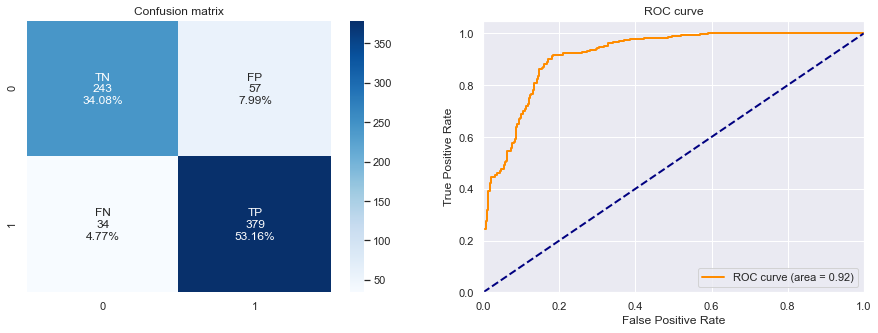

0,872
0,157
0,869
0,917
0,892
0,918


(0.8723702664796634,
 0.15771230502599642,
 0.8692660550458715,
 0.9176755447941889,
 0.8928150765606596,
 0.9183212267958031)

In [103]:
print('logistic regression + tf-idf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)